In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import pickle
import anndata as ad
from scipy.stats import norm
import os
from tqdm.notebook import tqdm
sys.path.append("../roi_analysis/")
from neighbor_graphs import NeighborEnricher
sys.path.append("../data_utils/")
from data_utils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme("paper")

In [4]:
base = "/data_nfs/"
dataset = group = "Melanoma"
data = get_data_csv(base=base, dataset=dataset, group=group)


with open(os.path.join(base, "je30bery/melanoma_data/cell_type_analysis/THEORETIC/cell_coordinates.pickle"), 'rb') as handle:
    cell_coordinates = pickle.load(handle)

data = data[data["file_path"].isin(list(cell_coordinates.keys()))]

data = data.reset_index()

In [51]:
ne = NeighborEnricher(cell_coordinates, "/data_nfs/")
tumor_stages = [['T1a', 'T1b'], ['T2a', 'T2b'], ['T3a', 'T3b'], ['T4b']]

dfs = dict()
for i, tumor_stage in enumerate(tumor_stages):
    data_subset = data[data["Tumor stage"].isin(tumor_stage)]
    cts = list()
    rois = list()
    for fov in np.unique(data_subset["file_path"]):
        try:
            cell_types = ne.get_cell_types(fov)
            roi_cells = ne.get_roi_cells(fov)
            roi_info = np.zeros(len(cell_types))
            assert roi_cells[0] == 0
            roi_info[roi_cells[1:] - 1] = 1
            roi_info = roi_info.astype(bool)
            rois += list(roi_info)
            cts += cell_types
            assert len(cell_types) == len(list(roi_info)), f"{len(cell_types)}, {len(list(roi_info))}"
            assert len(cts) == len(rois)
        except IndexError:
            continue
    dfs[i] = pd.DataFrame(np.array([rois, cts]).T, columns=["In ROI", "Cell type"])

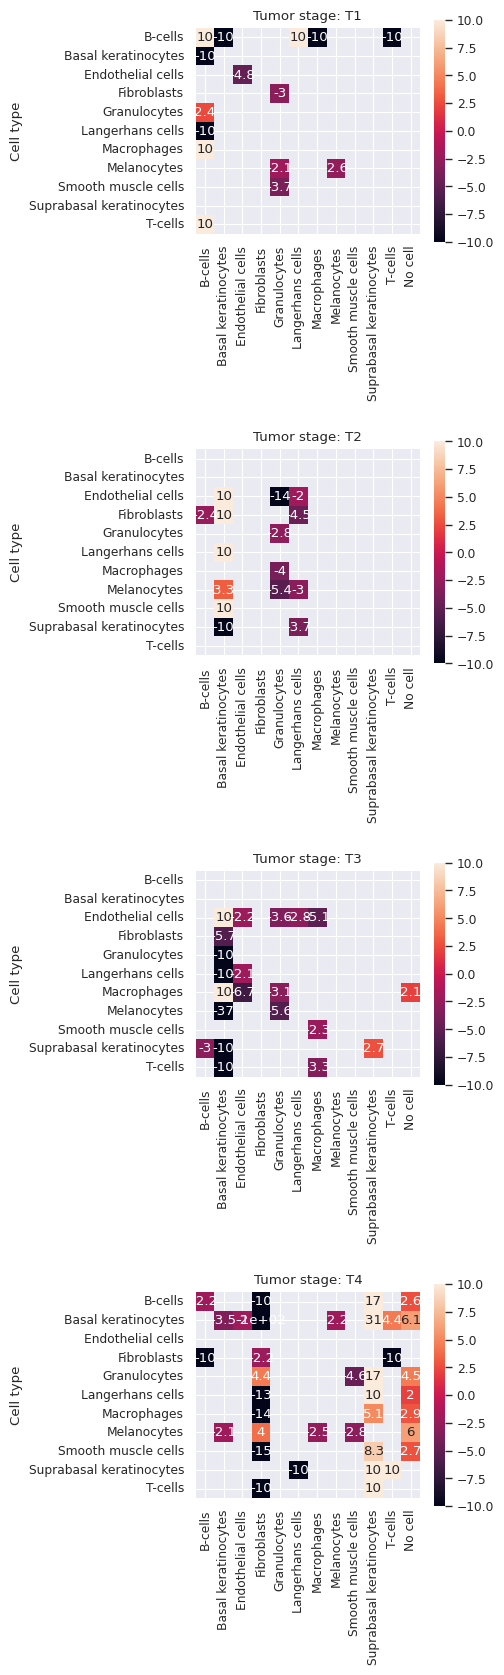

In [60]:
f, axs = plt.subplots(4, 1, sharey=True, figsize=(5, 17))
k = 20
for i, f in enumerate([f"T1a_T1b_z_scores_k={k}.csv", f"T2a_T2b_z_scores_k={k}.csv", f"T3a_T3b_z_scores_k={k}.csv", f"T4b_z_scores_k={k}.csv"]):
    z_scores = pd.read_csv(os.path.join("/data_nfs/je30bery/melanoma_data/MAGICAL/data/z_scores/combined_0-3", f)).rename({"Unnamed: 0": "Cell type"}, axis=1).set_index("Cell type").astype(float)
    z_scores.replace({np.inf:10, -np.inf:-10}, inplace=True)
    z_scores.rename({"nan":"No cell"}, axis=1, inplace=True)
    sns.heatmap(z_scores, vmax=10, vmin=-10, ax=axs[i], annot=True, square=True, mask=np.abs(z_scores) < 1.96)
    tumor_stage = f.split("_")[0][:2]
    axs[i].set_title(f"Tumor stage: {tumor_stage}")
plt.tight_layout()
plt.show()

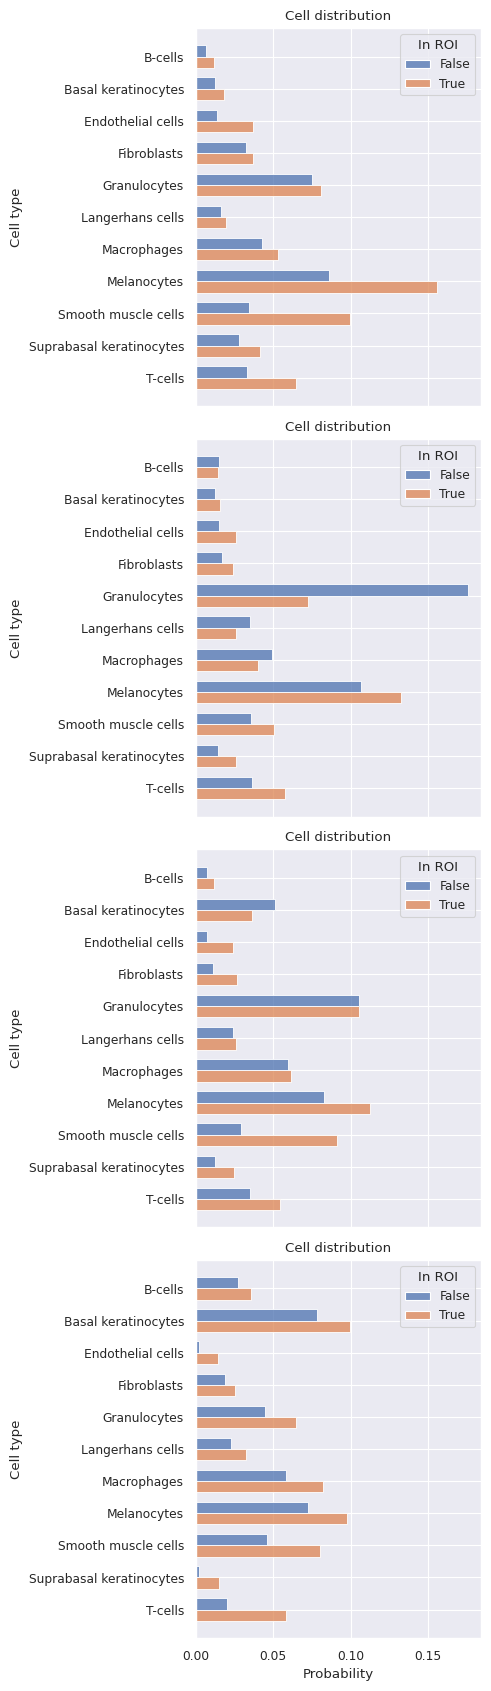

In [62]:
f, axs = plt.subplots(4, 1, sharey=True, sharex="col", figsize=(5, 17))
k = 11
for i, f in enumerate([f"T1a_T1b_z_scores_k={k}.csv", f"T2a_T2b_z_scores_k={k}.csv", f"T3a_T3b_z_scores_k={k}.csv", f"T4b_z_scores_k={k}.csv"]):
    sns.histplot(dfs[i].sort_values("Cell type"), y="Cell type", hue="In ROI", ax=axs[i], shrink=0.7, multiple="dodge", hue_order=["False", "True"], stat="probability")
    axs[i].set_title(f"Cell distribution")
plt.tight_layout()
plt.show()

In [45]:
dfs[i]["roi"]

0        0.0
1        0.0
2        1.0
3        0.0
4        1.0
        ... 
40707    1.0
40708    1.0
40709    1.0
40710    1.0
40711    1.0
Name: roi, Length: 40712, dtype: object

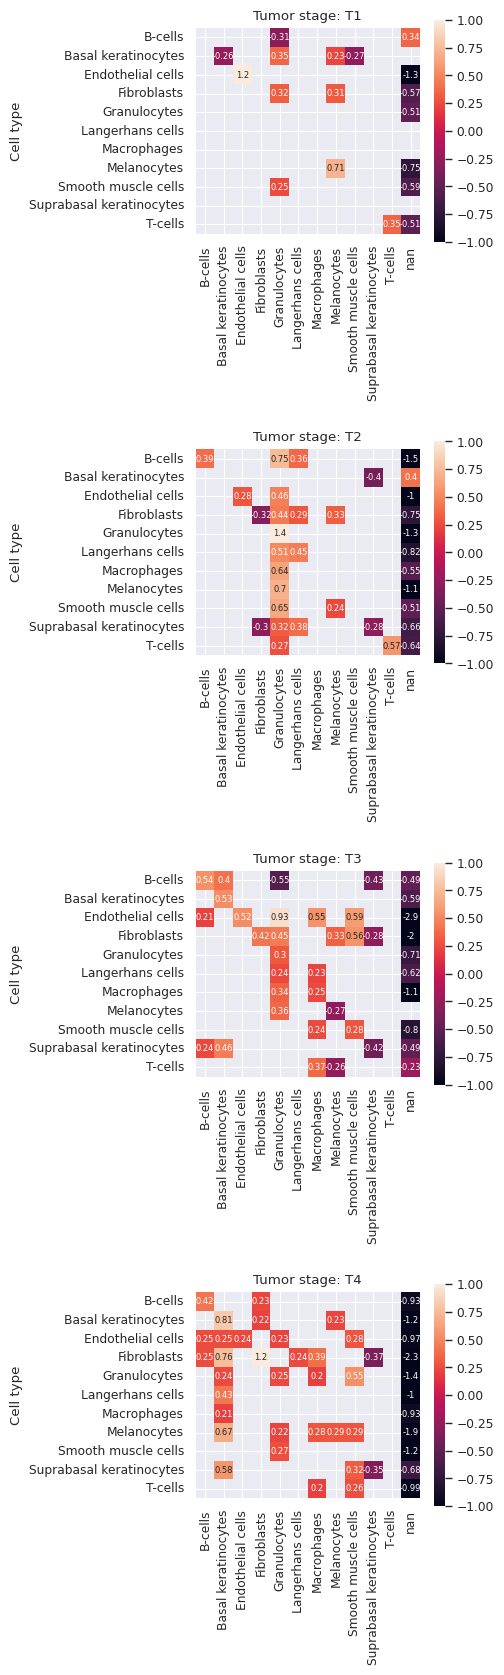

In [81]:
layer = "combined_0-3"
f, axs = plt.subplots(4, 1, sharey=True, figsize=(5, 17))
k = 20
tumor_stages = [['T1a', 'T1b'], ['T2a', 'T2b'], ['T3a', 'T3b'], ['T4b']]

for i, tumor_stage in enumerate(tumor_stages):
    ts = "_".join(tumor_stage)
    roi = pd.read_csv(os.path.join(base, f"je30bery/melanoma_data/MAGICAL/data/z_scores/{layer}/{ts}_roi_k={k}.csv")).rename({"Unnamed: 0": "Cell type"}, axis=1).set_index("Cell type").astype(float)
    rni = pd.read_csv(os.path.join(base, f"je30bery/melanoma_data/MAGICAL/data/z_scores/{layer}/{ts}_rni_k={k}.csv")).rename({"Unnamed: 0": "Cell type"}, axis=1).set_index("Cell type").astype(float)
    diff = rni-roi
    #z_scores = pd.read_csv(os.path.join("/data_nfs/je30bery/melanoma_data/MAGICAL/data/z_scores/combined_0-3", f)).rename({"Unnamed: 0": "Cell type"}, axis=1).set_index("Cell type").astype(float)
    #z_scores.replace({np.inf:10, -np.inf:-10}, inplace=True)
    sns.heatmap(diff, vmax=1, vmin=-1, ax=axs[i], annot=True, square=True, mask=np.abs(diff) < 0.2, annot_kws={"fontsize":6})
    tumor_stage = tumor_stage[0][:2]
    axs[i].set_title(f"Tumor stage: {tumor_stage}")
plt.tight_layout()
plt.show()

In [ ]:
f, axs= plt.subplots(1, 2, figsize=(15, 5))

z = (diff-means)/stds
sns.heatmap(z, mask=z<4, annot=True, ax = axs[0])
pvals = pd.DataFrame(2 * (1 - norm.cdf(abs(z))), index=z.index, columns=z.columns)
sns.heatmap(pvals, mask=(np.abs(pvals) > 0.001), annot=True, ax = axs[1])
axs[0].set_title("Z-score of difference in neighbor distribution ROI versus rest")
axs[1].set_title("P-value of difference in neighbor distribution ROI versus rest")

In [ ]:
# ne = NeighborEnricher()
# nbs = ne.get_neighbors(data, cell_type_path, cell_coordinates, cell_type_colors)
z = dict()
for i in [2, 5, 7, 10, 15, 20]:
    nbc = ne.get_neighbor_counts(nbs, i)
    nbc = nbc[nbc["Type"] == "Superficial Spreading Melanoma"].drop(["Type", "field_of_view"], axis=1)
    roi, rni, diff = ne.get_neighbour_count_difference(nbc, False)
    means, stds = ne.get_pvalues_for_neighbors(nbc, diff, 1000)
    z[i] = (diff-means)/stds

In [ ]:
f, axs= plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(z, mask=z<4, annot=True, ax = axs[0])
pvals = pd.DataFrame(2 * (1 - norm.cdf(abs(z))), index=z.index, columns=z.columns)
sns.heatmap(pvals, mask=(np.abs(pvals) > 0.01), annot=True, ax = axs[1])
axs[0].set_title("Z-score of difference in neighbor distribution ROI versus rest")
axs[1].set_title("P-value of difference in neighbor distribution ROI versus rest")